In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import numpy as np
import pandas as pd 
import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler

import lightgbm as lgb
import optuna
from optuna.samplers import TPESampler

import itertools


In [2]:
sample_solution = pd.read_csv('./sample_solution.csv')
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [3]:
sample_solution.head(5)

,id,claim
0,957919,0.5
1,957920,0.5
2,957921,0.5
3,957922,0.5
4,957923,0.5


In [4]:
train_df.head(5)

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
0,0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1
1,1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0
2,2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,1
3,3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,1
4,4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,1


In [5]:
test_df.head(5)

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
0,957919,0.165850,0.487050,1295.00,0.02310,0.31900,0.90188,573.29,3743.7,2.705700e+12,...,0.16253,-22.1890,2.0655,0.430880,-10.7410,81606.0,1.1940,1.980400e+14,2017.1,0.46357
1,957920,0.129650,0.373480,1763.00,0.72884,0.33247,-1.26310,875.55,554370.0,5.955700e+14,...,0.81528,-1.6342,1.5736,-1.071200,11.8320,90114.0,1.1507,4.388000e+16,6638.9,0.28125
2,957921,0.120190,0.445210,736.26,0.04615,0.29605,0.31665,2659.50,317140.0,3.977800e+14,...,0.81831,-32.7800,2.1364,-1.931200,-3.2804,37739.0,1.1548,1.718100e+14,5844.0,0.13797
3,957922,0.054008,0.395960,996.14,0.85934,0.36678,-0.17060,386.56,325680.0,-3.432200e+13,...,0.86559,-2.4162,1.5199,-0.011633,1.3840,26849.0,1.1490,2.138800e+17,6173.3,0.32910
4,957923,0.079947,-0.006919,10574.00,0.34845,0.45008,-1.84200,3027.00,428150.0,9.291500e+11,...,0.25190,-18.6300,3.7387,0.757080,-4.9405,50336.0,1.2488,2.151300e+17,2250.1,0.33796


## Code

In [6]:
train_df_labels = train_df['claim'].to_frame()
train_df = train_df.drop(columns=['claim', 'id'], axis=1)

print(train_df.shape)
print(train_df_labels.shape)

(957919, 118)
(957919, 1)


In [7]:
train_df.isnull().sum(axis = 0).sort_values(ascending=False)
train_df['NANs'] = train_df.isnull().sum(axis=1)
train_df['std'] = train_df.std(axis=1)
train_df['skew'] = train_df.skew(axis=1)
train_df['mean'] = train_df.mean(axis=1)
train_df["top_mean"] = train_df[["f40","f70","f47","f34","f35","f45"]].mean(axis=1)

In [8]:
scaler = MinMaxScaler() 
scaler.fit(train_df)

MinMaxScaler()

In [9]:

def create_model(trial):
    num_leaves = trial.suggest_int("num_leaves", 20, 40)
    n_estimators = trial.suggest_int("n_estimators", 200, 450)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    min_child_samples = trial.suggest_int('min_child_samples', 200, 750)
    learning_rate = trial.suggest_uniform('learning_rate', 0.10, 0.30)
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.50, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.50, 1.0)
    
        
    model = lgb.LGBMClassifier(
        objective='binary',
        metric='binary_logloss',
        num_leaves=num_leaves,
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_child_samples=min_child_samples, 
        learning_rate=learning_rate,
        colsample_bytree=colsample_bytree,
        random_state=seed
    )
    
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(train_df, train_df_labels)
    #see link in markdown above for this next line
    score = sklearn.metrics.roc_auc_score(valid_df_labels, model.predict_proba(valid_df)[:,1])
    return score

In [10]:
fold_models = []
n_folds = 10
folds = KFold(n_splits = n_folds, shuffle = True)

In [11]:
for train_index, test_index in folds.split(train_df):
    fold_train_df, fold_valid_df = train_df.iloc[train_index,:], train_df.iloc[test_index,:]
    #ravel creates a flattened array
    fold_train_labels, fold_test_labels = train_df_labels.iloc[train_index].values.ravel(), \
                                          train_df_labels.iloc[test_index].values.ravel()
        
    params = {'num_leaves': 28,
              'n_estimators': 376,
              'max_depth': 8,
              'min_child_samples': 202,
              'learning_rate': 0.11682677767413432,
              'bagging_fraction': 0.5036513634677549,
              'colsample_bytree': 0.7519268943195143
             }
        
    model = lgb.LGBMClassifier(**params)
    model.fit(fold_train_df, fold_train_labels)
    
    fold_models.append(model)

[LightGBM] [Warning] bagging_fraction is set=0.5036513634677549, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5036513634677549


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

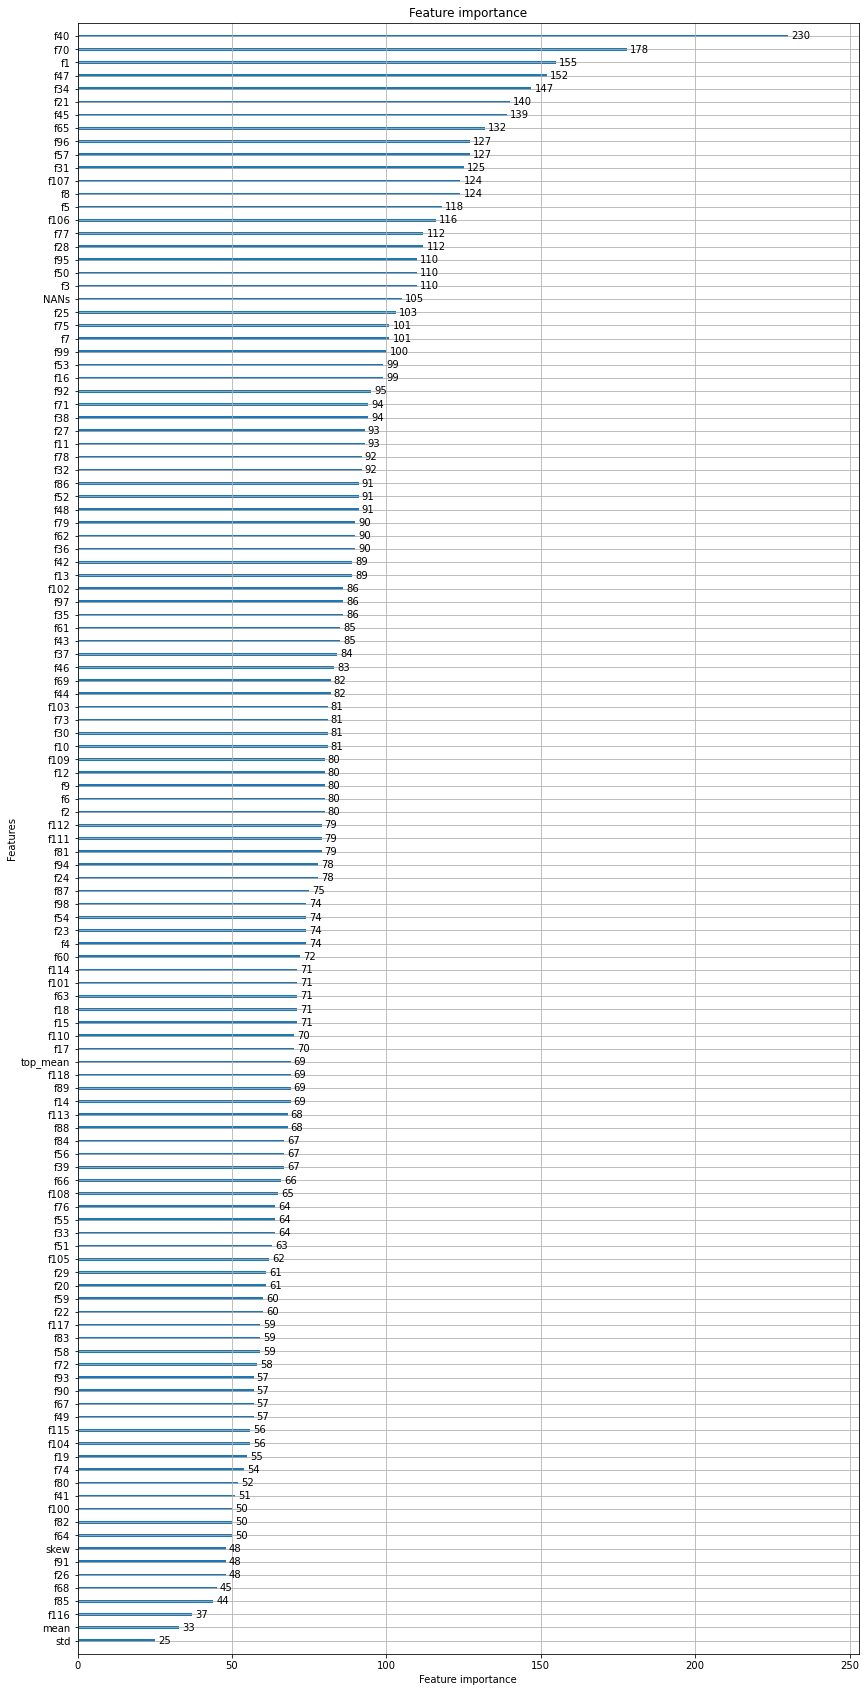

In [12]:

#lgb.plot_importance(model,figsize=(14,30))
lgb.plot_importance(fold_models[3],figsize=(14,30))

In [13]:
#preprocessing test_data
submission_df = test_df['id'].to_frame()
test_df = test_df.drop(columns=['id'], axis=0)

#adding feats
test_df['NANs'] = test_df.isnull().sum(axis=1)
test_df['std'] = test_df.std(axis=1)
test_df['skew'] = test_df.skew(axis=1)
test_df['mean'] = test_df.mean(axis=1)
test_df["top_mean"] = test_df[["f40","f70","f47","f34","f35","f45"]].mean(axis=1)

#fitting scaler
test_df = pd.DataFrame(scaler.fit_transform(test_df),columns = test_df.columns)
test_df[test_df < 0] = 0
test_df[test_df > 1] = 1

In [14]:
all_preds = np.zeros(len(test_df))

for i in range(n_folds):
    all_preds += fold_models[i].predict_proba(test_df)[:,1]
    
all_preds /= n_folds
submission_df['claim'] = all_preds
submission_df.to_csv("submission.csv", index=False)

submission_df

,id,claim
0,957919,0.251883
1,957920,0.049643
2,957921,0.238372
3,957922,0.063351
4,957923,0.044658
...,...,...
493469,1451388,0.236014
493470,1451389,0.046262
493471,1451390,0.288617
493472,1451391,0.052459
